SpaCy 'en_core_web_sm' 모델이 성공적으로 로드되었습니다.
제공된 문자열 문장들로 지식 그래프를 구축합니다...


지식 그래프 구축: 100%|██████████| 11/11 [00:00<00:00, 166.80it/s]

지식 그래프 구축 완료. 총 11개의 문장을 처리했습니다.
지식 그래프에는 현재 86개의 노드와 126개의 엣지가 있습니다.
전체 지식 그래프를 시각화합니다: 노드 수 86, 엣지 수 126
지식 그래프 시각화를 시작합니다...


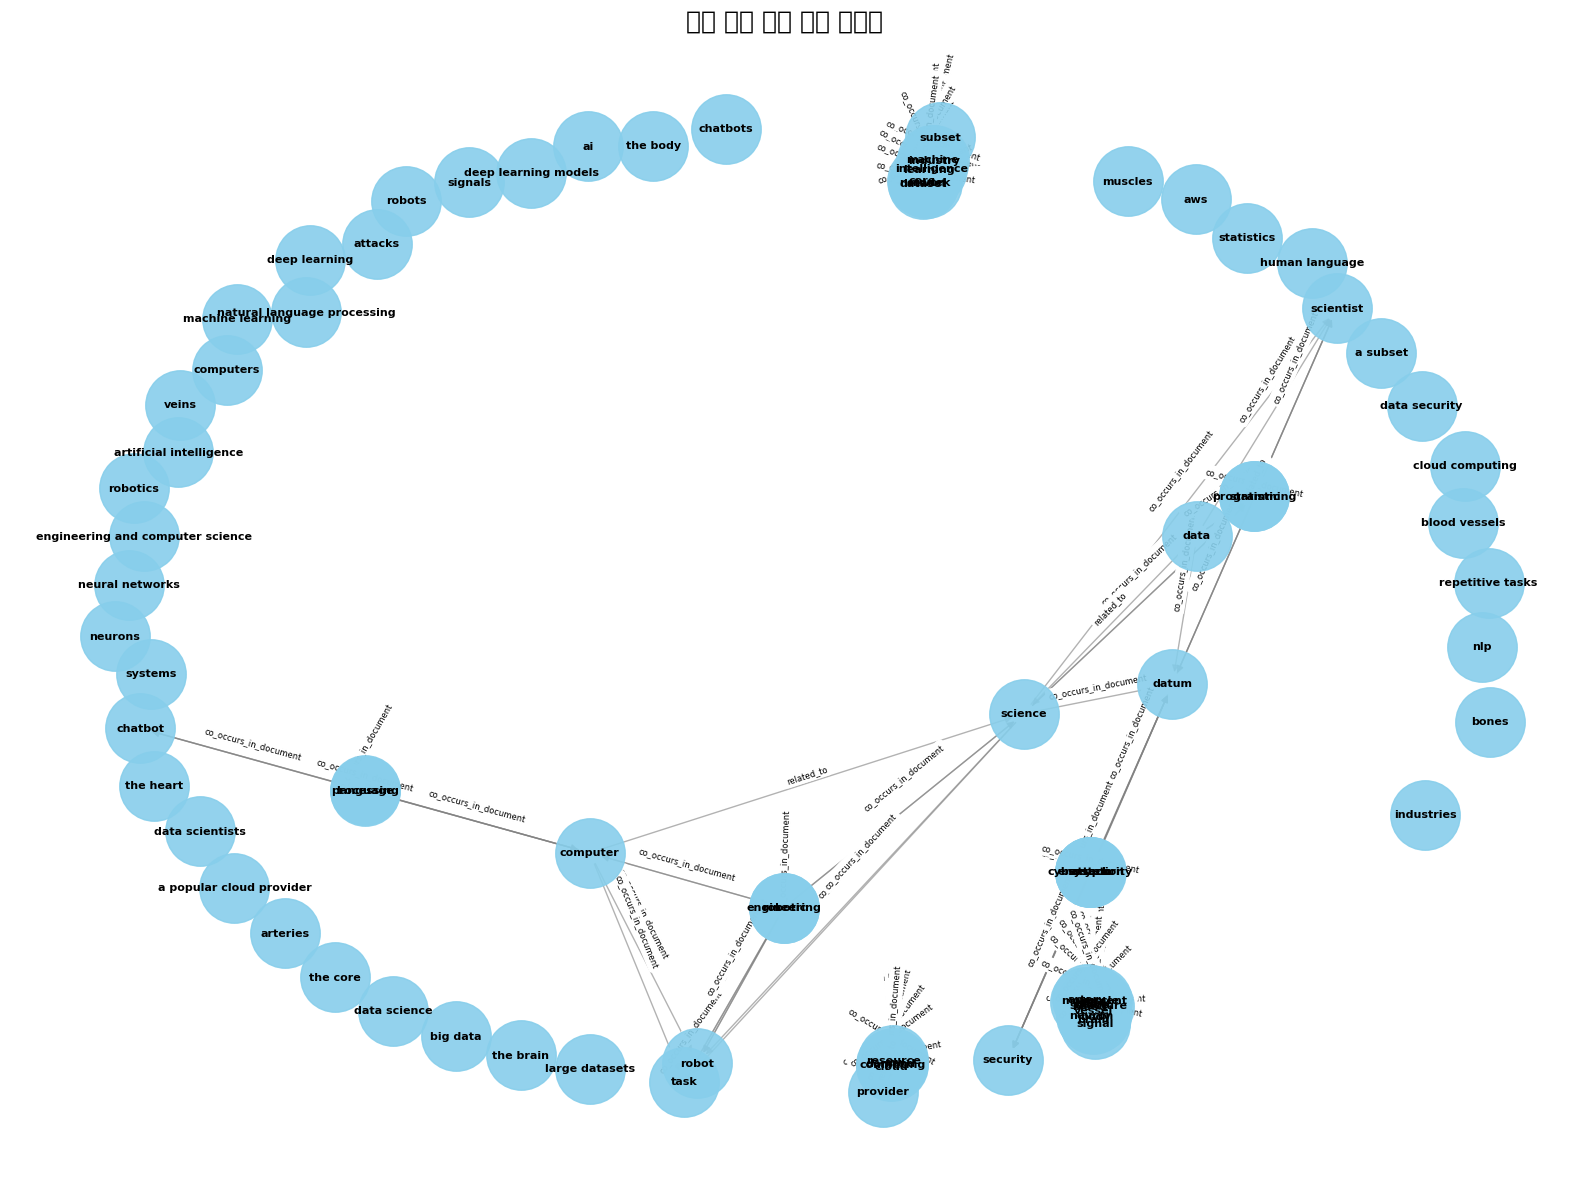

지식 그래프 시각화가 완료되었습니다.


: 

In [ ]:
import os
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

try:
    nlp = spacy.load("en_core_web_sm")
    print("SpaCy 'en_core_web_sm' 모델이 성공적으로 로드되었습니다.")
except OSError:
    print("SpaCy 'en_core_web_sm' 모델을 다운로드합니다...")
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
    print("SpaCy 'en_core_web_sm' 모델 다운로드 및 로드 완료.")

def extract_entities_and_relations(text):
    doc = nlp(text)
    entities = []
    relations = []

    for chunk in doc.noun_chunks:
        entities.append(chunk.text.lower())

    for i in range(len(doc) - 1):
        token1 = doc[i]
        token2 = doc[i+1]

        if token1.pos_ == "NOUN" and token2.pos_ == "NOUN":
            relations.append((token1.lemma_.lower(), "has_part" if token2.dep_ == "compound" else "related_to", token2.lemma_.lower()))
        elif token1.ent_type_ and token2.ent_type_:
            relations.append((token1.text.lower(), "co_occurs_with", token2.text.lower()))
        elif token1.pos_ == "NOUN" and token2.dep_ == "prep" and i + 2 < len(doc) and doc[i+2].pos_ == "NOUN":
            relations.append((token1.lemma_.lower(), "is_" + token2.text.lower() + "_of", doc[i+2].lemma_.lower()))
            
    extracted_nouns = []
    for token in doc:
        if token.pos_ == "NOUN":
            extracted_nouns.append(token.lemma_.lower())

    for i in range(len(extracted_nouns)):
        for j in range(i + 1, len(extracted_nouns)):
            if extracted_nouns[i] != extracted_nouns[j]:
                relations.append((extracted_nouns[i], "co_occurs_in_document", extracted_nouns[j]))

    for sent in doc.sents :
        for token in sent :
            if token.dep_ == "nsubj" and token.head.pos == "VERB" :
                if token.head.dep_ == "ROOT" :
                    pass
            if token.pos_ == "NOUN" :
                for child in token.children :
                    if child.pos_ == "VERB" :
                        for grandchild in child.children :
                            if grandchild.pos_ == "NOUN" and grandchild.dep_ in ["dobj", "pobj"] :
                                relations.append((token.lemma_.lower(), child.lemma_.lower(), grandchild.lemma_.lower()))

            if token.pos_ == "NOUN" :
                for child in token.children :
                    if child.dep_ == "prep" :
                        for grandchild in child.children :
                            if grandchild.pos_ == "NOUN" and grandchild.dep_ == "pobj" :
                                relations.append((token.lemma_.lower(), f"is_{child.lemma_.lower()}_of", grandchild.lemma_.lower()))
    
    entities = list(set(entities + extracted_nouns))
    relations = list(set(relations))

    return entities, relations

def clean_markdown(md_text):
    text = re.sub(r'^#+\s*.*$', '', md_text, flags=re.MULTILINE)
    text = re.sub(r'(\*\*|__)(.*?)\1', r'\2', text)
    text = re.sub(r'(\*|_)(.*?)\1', r'\2', text)
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
    text = re.sub(r'^\s*[-*+]\s+', '', text, flags=re.MULTILINE)
    text = re.sub(r'^-{3,}\s*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'^\*{3,}\s*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'```.*?```', '', text, flags=re.DOTALL)
    text = re.sub(r'`(.*?)`', r'\1', text)
    text = re.sub(r'\n\n+', '\n', text)
    return text.strip()

def build_knowledge_graph_from_strings(text_list):
    G = nx.DiGraph()
    print("제공된 문자열 문장들로 지식 그래프를 구축합니다...")
    
    for i, text in enumerate(tqdm(text_list, desc="지식 그래프 구축")):
        plain_text = clean_markdown(text)
        entities, relations = extract_entities_and_relations(plain_text)

        for entity in entities:
            G.add_node(entity)

        for subj, pred, obj in relations:
            if subj in G.nodes and obj in G.nodes:
                G.add_edge(subj, obj, relation=pred)
            else:
                if subj not in G.nodes:
                    G.add_node(subj)
                if obj not in G.nodes:
                    G.add_node(obj)
                G.add_edge(subj, obj, relation=pred)
    
    print(f"지식 그래프 구축 완료. 총 {len(text_list)}개의 문장을 처리했습니다.")
    print(f"지식 그래프에는 현재 {G.number_of_nodes()}개의 노드와 {G.number_of_edges()}개의 엣지가 있습니다.")
    return G

def visualize_graph(graph, title="Knowledge Graph"):
    print("지식 그래프 시각화를 시작합니다...")
    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(graph, k=0.07, iterations=200, seed=42) 

    nx.draw_networkx_nodes(graph, pos, node_size=2500, node_color="skyblue", alpha=0.9)
    nx.draw_networkx_labels(graph, pos, font_size=8, font_weight="bold")
    
    nx.draw_networkx_edges(graph, pos, edge_color="gray", arrows=True, alpha=0.6)
    edge_labels = nx.get_edge_attributes(graph, 'relation')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=6, verticalalignment='baseline')

    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()
    print("지식 그래프 시각화가 완료되었습니다.")

if __name__ == "__main__":
    sample_sentences = [
        "Artificial intelligence is transforming industries. Machine learning is a subset of AI.",
        "Deep learning models require large datasets. Neural networks are the core of deep learning.",
        "Natural language processing helps computers understand human language. Chatbots use NLP.",
        "Robotics combines engineering and computer science. Robots can perform repetitive tasks.",
        "Data science involves statistics and programming. Big data is analyzed by data scientists.",
        "Cybersecurity protects systems from attacks. Encryption is vital for data security.",
        "Cloud computing provides on-demand resources. AWS is a popular cloud provider.",
        "The brain controls the body. Neurons transmit signals in the brain.",
        "The heart pumps blood. Blood vessels carry blood throughout the body.",
        "Muscles enable movement. Bones provide structure to the body.",
        "Arteries carry blood away from the heart. Veins return blood to the heart."
    ]

    knowledge_graph = build_knowledge_graph_from_strings(sample_sentences)

    print(f"전체 지식 그래프를 시각화합니다: 노드 수 {knowledge_graph.number_of_nodes()}, 엣지 수 {knowledge_graph.number_of_edges()}")
    
    if knowledge_graph.number_of_nodes() > 0:
        visualize_graph(knowledge_graph, title="전체 샘플 문장 지식 그래프")
    else:
        print("그래프에 노드가 없어 시각화할 수 없습니다.")